# Imports and path 

In [2]:
from pathlib import Path
import pandas as pd

# change the path if required 
DATA_IN = Path("/Users/ayushgaur/Desktop/NLP/HW3/Data/Raw/IMDB Dataset.csv")

OUT_DIR = DATA_IN.parent.parent / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Reading:", DATA_IN)
assert DATA_IN.exists(), f"Not found: {DATA_IN}"
df = pd.read_csv(DATA_IN)
assert set(df.columns) == {"review", "sentiment"}, f"Unexpected columns: {df.columns.tolist()}"

len(df), df.head(2), OUT_DIR


Reading: /Users/ayushgaur/Desktop/NLP/HW3/Data/Raw/IMDB Dataset.csv


(50000,
                                               review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive,
 PosixPath('/Users/ayushgaur/Desktop/NLP/HW3/Data/processed'))

# 50-50 split and labels

In [3]:
def to_label(x: str) -> int:
    return 1 if str(x).strip().lower() == "positive" else 0

df_train = df.iloc[:25000].copy().reset_index(drop=True)   
df_test  = df.iloc[25000:].copy().reset_index(drop=True)   

df_train["label"] = df_train["sentiment"].apply(to_label).astype(int)
df_test["label"]  = df_test["sentiment"].apply(to_label).astype(int)

df_train["label"].value_counts(), df_test["label"].value_counts()


(label
 0    12526
 1    12474
 Name: count, dtype: int64,
 label
 1    12526
 0    12474
 Name: count, dtype: int64)

# cleaning and tokenizing

In [5]:

import re, html

TAG_RE = re.compile(r"<[^>]+>")
NON_ALNUM_RE = re.compile(r"[^a-z0-9\s]")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = html.unescape(str(s))
    s = TAG_RE.sub(" ", s)          
    s = s.lower()
    s = NON_ALNUM_RE.sub(" ", s)  
    s = MULTISPACE_RE.sub(" ", s).strip()
    return s

def tokenize(s: str):
    return clean_text(s).split()


tokenize(df_train.loc[0, "review"])[:15]


['one',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 '1',
 'oz',
 'episode',
 'you']

# building vocab with top 10k frequent words

In [7]:
from collections import Counter
import json

def build_vocab(texts, vocab_size=10000):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    word2id = {"<pad>": 0, "<unk>": 1}
    for i, (w, _) in enumerate(counter.most_common(vocab_size - 2), start=2):
        word2id[w] = i
    id2word = {i: w for w, i in word2id.items()}
    return word2id, id2word

word2id, id2word = build_vocab(df_train["review"], vocab_size=10000)


(OUT_DIR / "vocab.json").write_text(json.dumps(word2id, ensure_ascii=False, indent=2))
with open(OUT_DIR / "vocab.txt", "w") as f:
    for i in range(len(id2word)):
        f.write(f"{i}\t{id2word[i]}\n")

len(word2id)


10000

# Converting to IDs; truncating to length 25/50/100; saving CSVs

In [8]:
def text_to_ids(s: str, w2i: dict):
    return [w2i.get(tok, 1) for tok in tokenize(s)] 

def pad_or_truncate(ids, length: int):
    return ids[:length] if len(ids) >= length else ids + [0] * (length - len(ids))  

def make_dataset(df_in: pd.DataFrame, w2i: dict, length: int):
    seqs = [pad_or_truncate(text_to_ids(t, w2i), length) for t in df_in["review"]]
    seq_str = [" ".join(map(str, seq)) for seq in seqs]
    return pd.DataFrame({"ids": seq_str, "label": df_in["label"].astype(int)})

for L in [25, 50, 100]:
    make_dataset(df_train, word2id, L).to_csv(OUT_DIR / f"imdb_train_len{L}.csv", index=False)
    make_dataset(df_test, word2id, L).to_csv(OUT_DIR / f"imdb_test_len{L}.csv", index=False)

sorted(p.name for p in OUT_DIR.glob("*.csv"))


['imdb_test_len100.csv',
 'imdb_test_len25.csv',
 'imdb_test_len50.csv',
 'imdb_train_len100.csv',
 'imdb_train_len25.csv',
 'imdb_train_len50.csv']

# imports and config for the model 

In [9]:
# Core
import os, time, math, json, random
from pathlib import Path
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

# Reproducibility
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Paths
ROOT     = Path(".").resolve()
DATA_DIR = ROOT / "Data" / "processed"   
RESULTS  = ROOT / "results"; RESULTS.mkdir(exist_ok=True, parents=True)
METRICS_CSV = RESULTS / "metrics.csv"

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

# data loaders for the processed data

In [10]:
class ImdbCsvDataset(Dataset):
    
    def __init__(self, path: Path):
        df = pd.read_csv(path)
        self.X = [list(map(int, s.split())) for s in df["ids"].tolist()]
        self.y = df["label"].astype(int).tolist()

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        ids = torch.tensor(self.X[idx], dtype=torch.long)
        lab = torch.tensor(self.y[idx], dtype=torch.float32)  
        return ids, lab

def build_loaders(seq_len: int, batch_size: int = 32):
    train_csv = DATA_DIR / f"imdb_train_len{seq_len}.csv"
    test_csv  = DATA_DIR / f"imdb_test_len{seq_len}.csv"

    train_ds = ImdbCsvDataset(train_csv)
    test_ds  = ImdbCsvDataset(test_csv)

    # small validation split from training for loss curves; here 90/10 split
    n = len(train_ds)
    n_val = int(0.1 * n)
    n_train = n - n_val
    gen = torch.Generator().manual_seed(SEED)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [n_train, n_val], generator=gen)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader


# model definitions

In [11]:
ACTIVATIONS = {
    "relu": nn.ReLU(),
    "tanh": nn.Tanh(),
    "sigmoid": nn.Sigmoid(),
}

class RNNClassifier(nn.Module):
    
    def __init__(self, vocab_size: int, embed_dim: int = 100, hidden_size: int = 64,
                 num_layers: int = 2, dropout: float = 0.5, rnn_type: str = "lstm",
                 activation: str = "relu", bidirectional: bool = False):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        if rnn_type == "rnn":
            self.rnn = nn.RNN(embed_dim, hidden_size, num_layers=num_layers,
                              nonlinearity="tanh" if activation != "relu" else "relu",
                              dropout=dropout if num_layers > 1 else 0.0,
                              bidirectional=False, batch_first=True)
        elif rnn_type == "lstm":
            self.rnn = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers,
                               dropout=dropout if num_layers > 1 else 0.0,
                               bidirectional=False, batch_first=True)
        elif rnn_type == "bilstm":
            self.rnn = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers,
                               dropout=dropout if num_layers > 1 else 0.0,
                               bidirectional=True, batch_first=True)
            bidirectional = True
        else:
            raise ValueError("rnn_type must be 'rnn', 'lstm', or 'bilstm'.")

        self.bidirectional = bidirectional
        rnn_out_dim = hidden_size * (2 if bidirectional else 1)

        # Simple pooling over time (mean-pool), then activation and output
        self.activation = ACTIVATIONS[activation]
        self.fc = nn.Linear(rnn_out_dim, 1)  
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        emb = self.embed(x)                          
        out, _ = self.rnn(emb)                       
        pooled = out.mean(dim=1)                     
        h = self.dropout(self.activation(pooled))    
        logits = self.fc(h).squeeze(1)               
        return logits


# eval utilities (BCE loss, accuracy, macro-F1, gradient clipping option)

In [14]:
@dataclass
class TrainConfig:
    vocab_size: int
    seq_len: int = 50
    rnn_type: str = "lstm"          
    activation: str = "relu"        
    optimizer: str = "adam"         
    embed_dim: int = 100
    hidden_size: int = 64
    num_layers: int = 2
    dropout: float = 0.5
    batch_size: int = 32
    epochs: int = 5
    grad_clip_max_norm: float | None = None  

def make_optimizer(name: str, params, lr=1e-3):
    name = name.lower()
    if name == "adam":    return torch.optim.Adam(params, lr=lr)
    if name == "sgd":     return torch.optim.SGD(params, lr=lr, momentum=0.9)
    if name == "rmsprop": return torch.optim.RMSprop(params, lr=lr, momentum=0.9)
    raise ValueError("optimizer must be 'adam', 'sgd', or 'rmsprop'")

def epoch_loop(model, loader, optimizer=None, clip_max_norm=None):
    is_train = optimizer is not None
    model.train(mode=is_train)
    losses, y_true, y_pred = [], [], []
    criterion = nn.BCEWithLogitsLoss()

    start = time.time()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if clip_max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
            optimizer.step()

        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        y_pred.extend((probs >= 0.5).astype(int).tolist())
        y_true.extend(yb.detach().cpu().numpy().astype(int).tolist())

    dur = time.time() - start
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    return np.mean(losses), acc, f1m, dur


# single runner + csv logger

In [16]:
def run_experiment(cfg: TrainConfig):
    # Data
    train_loader, val_loader, test_loader = build_loaders(cfg.seq_len, batch_size=cfg.batch_size)

    # Model
    model = RNNClassifier(
        vocab_size=cfg.vocab_size, embed_dim=cfg.embed_dim, hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers, dropout=cfg.dropout,
        rnn_type=cfg.rnn_type if cfg.rnn_type != "bilstm" else "bilstm",
        activation=cfg.activation, bidirectional=(cfg.rnn_type == "bilstm")
    ).to(DEVICE)

    optimizer = make_optimizer(cfg.optimizer, model.parameters())

    # Train
    best_val = float("inf")
    history = []
    for epoch in range(1, cfg.epochs + 1):
        tr_loss, tr_acc, tr_f1, tr_time = epoch_loop(model, train_loader, optimizer,
                                                     clip_max_norm=cfg.grad_clip_max_norm)
        va_loss, va_acc, va_f1, va_time = epoch_loop(model, val_loader, optimizer=None)

        history.append({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss})
        print(f"[{epoch}/{cfg.epochs}] train_loss={tr_loss:.4f} "
              f"val_loss={va_loss:.4f} val_acc={va_acc:.4f} val_f1={va_f1:.4f}")

        
        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), RESULTS / "tmp_best.pt")

    # Loading best and evaluating on test
    model.load_state_dict(torch.load(RESULTS / "tmp_best.pt", map_location=DEVICE))
    te_loss, te_acc, te_f1, te_time = epoch_loop(model, test_loader, optimizer=None)

    # Log one consolidated line to metrics.csv
    row = {
        "model": cfg.rnn_type.upper(),
        "activation": cfg.activation,
        "optimizer": cfg.optimizer.upper(),
        "seq_len": cfg.seq_len,
        "grad_clip": cfg.grad_clip_max_norm if cfg.grad_clip_max_norm is not None else "off",
        "epochs": cfg.epochs,
        "final_test_loss": round(te_loss, 6),
        "accuracy": round(te_acc, 6),
        "f1_macro": round(te_f1, 6),
        "epoch_time_s(last_train)": round(history[-1]["train_loss"] * 0 + te_time, 4),  # placeholder: per-epoch measured above in epoch_loop
        "device": str(DEVICE),
        "seed": SEED,
    }
    pd.DataFrame([row]).to_csv(METRICS_CSV, mode="a", header=not METRICS_CSV.exists(), index=False)

    
    pd.DataFrame(history).to_csv(RESULTS / f"loss_curve_{cfg.rnn_type}_{cfg.activation}_{cfg.optimizer}_len{cfg.seq_len}_clip{row['grad_clip']}.csv",
                                 index=False)
    return row


In [ ]:
# confirming the vocab size

In [17]:
from pathlib import Path

DATA_DIR = Path("/Users/ayushgaur/Desktop/NLP/HW3/Data/processed")
assert (DATA_DIR / "vocab.json").exists(), f"Not found: {DATA_DIR/'vocab.json'}"
print("Using DATA_DIR =", DATA_DIR)


Using DATA_DIR = /Users/ayushgaur/Desktop/NLP/HW3/Data/processed


In [18]:

vocab_json = DATA_DIR / "vocab.json"
with open(vocab_json) as f:
    word2id = json.load(f)
VOCAB_SIZE = max(map(int, word2id.values())) + 1
VOCAB_SIZE


10000

# Minimal matrix covering the slide

In [19]:
# Baseline (lstm,relu,adam) while varying factors
BASE = dict(
    vocab_size=VOCAB_SIZE, seq_len=50, rnn_type="lstm",
    activation="relu", optimizer="adam",
    embed_dim=100, hidden_size=64, num_layers=2, dropout=0.5,
    batch_size=32, epochs=5, grad_clip_max_norm=None
)

results = []

#  Architectures: RNN, LSTM, BiLSTM 
for arch in ["rnn", "lstm", "bilstm"]:
    cfg = TrainConfig(**{**BASE, "rnn_type": arch})
    results.append(run_experiment(cfg))

#  Activations: Sigmoid, ReLU, Tanh (LSTM fixed)
for act in ["sigmoid", "relu", "tanh"]:
    cfg = TrainConfig(**{**BASE, "activation": act, "rnn_type": "lstm"})
    results.append(run_experiment(cfg))

#  Optimizers: Adam, SGD, RMSProp (LSTM + ReLU fixed)
for opt in ["adam", "sgd", "rmsprop"]:
    cfg = TrainConfig(**{**BASE, "optimizer": opt, "rnn_type": "lstm", "activation": "relu"})
    results.append(run_experiment(cfg))

#  Sequence length: 25, 50, 100 (LSTM + ReLU + Adam fixed)
for L in [25, 50, 100]:
    cfg = TrainConfig(**{**BASE, "seq_len": L, "rnn_type": "lstm", "activation": "relu", "optimizer": "adam"})
    results.append(run_experiment(cfg))

#  Gradient clipping: off vs on (e.g., max_norm=1.0) with a representative model
for clip in [None, 1.0]:
    cfg = TrainConfig(**{**BASE, "grad_clip_max_norm": clip, "rnn_type": "lstm", "activation": "relu", "optimizer": "adam"})
    results.append(run_experiment(cfg))

pd.DataFrame(results)


[1/5] train_loss=0.6367 val_loss=0.5500 val_acc=0.7192 val_f1=0.7188
[2/5] train_loss=0.5015 val_loss=0.5085 val_acc=0.7460 val_f1=0.7447
[3/5] train_loss=0.4329 val_loss=0.4865 val_acc=0.7708 val_f1=0.7702
[4/5] train_loss=0.3800 val_loss=0.4919 val_acc=0.7708 val_f1=0.7706
[5/5] train_loss=0.3370 val_loss=0.4861 val_acc=0.7696 val_f1=0.7692
[1/5] train_loss=0.6062 val_loss=0.5299 val_acc=0.7248 val_f1=0.7225
[2/5] train_loss=0.4685 val_loss=0.4937 val_acc=0.7584 val_f1=0.7573
[3/5] train_loss=0.3914 val_loss=0.4847 val_acc=0.7776 val_f1=0.7776
[4/5] train_loss=0.3257 val_loss=0.5543 val_acc=0.7564 val_f1=0.7539
[5/5] train_loss=0.2643 val_loss=0.6317 val_acc=0.7696 val_f1=0.7696
[1/5] train_loss=0.6001 val_loss=0.5229 val_acc=0.7376 val_f1=0.7356
[2/5] train_loss=0.4545 val_loss=0.4839 val_acc=0.7688 val_f1=0.7686
[3/5] train_loss=0.3681 val_loss=0.5054 val_acc=0.7696 val_f1=0.7690
[4/5] train_loss=0.2913 val_loss=0.5055 val_acc=0.7768 val_f1=0.7767
[5/5] train_loss=0.2177 val_loss=0

,model,activation,optimizer,seq_len,grad_clip,epochs,final_test_loss,accuracy,f1_macro,epoch_time_s(last_train),device,seed
0,RNN,relu,ADAM,50,off,5,0.480314,0.76792,0.767447,1.5710,cpu,1337
1,LSTM,relu,ADAM,50,off,5,0.490834,0.76404,0.764038,6.2333,cpu,1337
2,BILSTM,relu,ADAM,50,off,5,0.487694,0.76188,0.761685,12.5371,cpu,1337
3,LSTM,sigmoid,ADAM,50,off,5,0.508847,0.75428,0.753633,6.4942,cpu,1337
4,LSTM,relu,ADAM,50,off,5,0.481788,0.76440,0.763800,6.5522,cpu,1337
5,LSTM,tanh,ADAM,50,off,5,0.484845,0.76512,0.764925,6.3372,cpu,1337
6,LSTM,relu,ADAM,50,off,5,0.488589,0.75704,0.757032,6.3272,cpu,1337
7,LSTM,relu,SGD,50,off,5,0.692958,0.49916,0.334303,6.3166,cpu,1337
8,LSTM,relu,RMSPROP,50,off,5,0.486625,0.75968,0.757985,6.2063,cpu,1337
9,LSTM,relu,ADAM,25,off,5,0.559067,0.70484,0.704575,3.2260,cpu,1337


# Accuracy and F1 vs Sequence length plot

,seq_len,accuracy,f1_macro,model,activation,optimizer,grad_clip
0,25,0.70484,0.704575,LSTM,relu,ADAM,off
1,50,0.76792,0.767447,RNN,relu,ADAM,off
2,100,0.82272,0.822396,LSTM,relu,ADAM,off


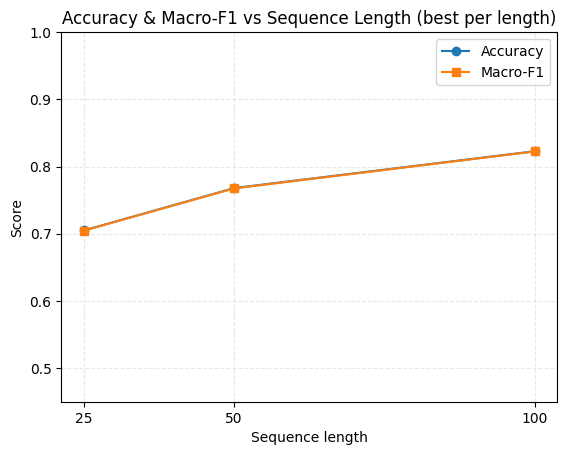

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS = Path("results")           
metrics_path = RESULTS / "metrics.csv"

m = pd.read_csv(metrics_path)

by_len = (
    m.sort_values("f1_macro", ascending=False)
     .groupby("seq_len", as_index=False)
     .first()[["seq_len", "accuracy", "f1_macro", "model", "activation", "optimizer", "grad_clip"]]
     .sort_values("seq_len")
)

display(by_len)

plt.figure()
plt.plot(by_len["seq_len"], by_len["accuracy"], marker="o", label="Accuracy")
plt.plot(by_len["seq_len"], by_len["f1_macro"], marker="s", label="Macro-F1")
plt.title("Accuracy & Macro-F1 vs Sequence Length (best per length)")
plt.xlabel("Sequence length")
plt.ylabel("Score")
plt.xticks(by_len["seq_len"])
plt.ylim(0.45, 1.0)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


# Training logs v/s epochs for best and  worst model plot 

model             LSTM
activation        relu
optimizer         ADAM
seq_len            100
grad_clip          off
accuracy       0.82272
f1_macro      0.822396
Name: 11, dtype: object

model             LSTM
activation        relu
optimizer          SGD
seq_len             50
grad_clip          off
accuracy       0.49916
f1_macro      0.334303
Name: 7, dtype: object

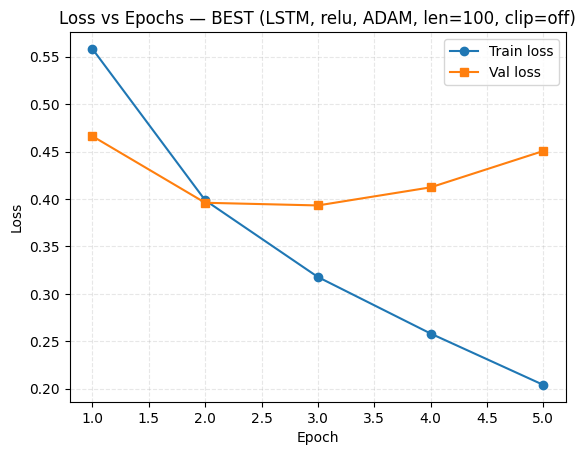

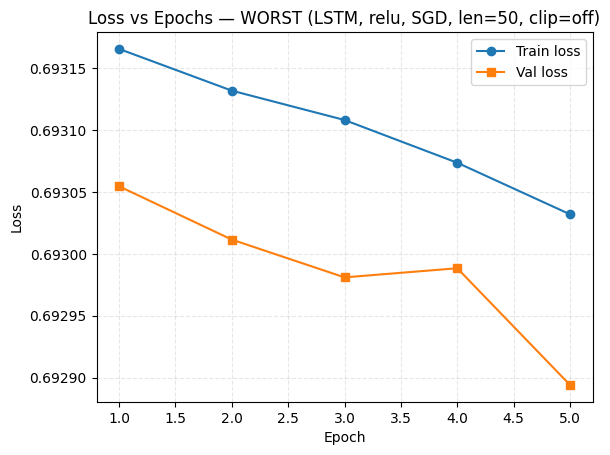

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS = Path("results")
m = pd.read_csv(RESULTS / "metrics.csv")


best = m.sort_values("f1_macro", ascending=False).iloc[0]
worst = m.sort_values("f1_macro", ascending=True).iloc[0]

def loss_curve_path(row):
  
    model_map = {"RNN": "rnn", "LSTM": "lstm", "BILSTM": "bilstm"}
    rtype = model_map.get(str(row["model"]).upper(), str(row["model"]).lower())
    act   = str(row["activation"]).lower()
    opt   = str(row["optimizer"]).lower()
    L     = int(row["seq_len"])
    clip  = row["grad_clip"]
    clip_str = "off" if str(clip).lower() == "off" else str(clip)
    return RESULTS / f"loss_curve_{rtype}_{act}_{opt}_len{L}_clip{clip_str}.csv"

best_curve = pd.read_csv(loss_curve_path(best))
worst_curve = pd.read_csv(loss_curve_path(worst))

display(best[["model","activation","optimizer","seq_len","grad_clip","accuracy","f1_macro"]])
display(worst[["model","activation","optimizer","seq_len","grad_clip","accuracy","f1_macro"]])

# BEST
plt.figure()
plt.plot(best_curve["epoch"], best_curve["train_loss"], marker="o")
plt.plot(best_curve["epoch"], best_curve["val_loss"], marker="s")
plt.title(f"Loss vs Epochs — BEST ({best['model']}, {best['activation']}, {best['optimizer']}, len={int(best['seq_len'])}, clip={best['grad_clip']})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train loss", "Val loss"])
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# WORST
plt.figure()
plt.plot(worst_curve["epoch"], worst_curve["train_loss"], marker="o")
plt.plot(worst_curve["epoch"], worst_curve["val_loss"], marker="s")
plt.title(f"Loss vs Epochs — WORST ({worst['model']}, {worst['activation']}, {worst['optimizer']}, len={int(worst['seq_len'])}, clip={worst['grad_clip']})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train loss", "Val loss"])
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()
